In [46]:
import pandas as pd
import numpy as np
import gower
import matplotlib.pyplot as plt


In [ ]:
# Load dataset
df = pd.read_csv("electricvehicles.csv")

# Drop unused column
df = df.drop(columns=["Segment"])

# Clean and preprocess
# df = df.dropna(subset=[
#     "AccelSec", "TopSpeed_KmH", "Range_Km", "Efficiency_WhKm",
#     "FastCharge_KmH", "RapidCharge", "Seats", "PriceEuro"
# ])

"""We noticed that a Cybertruck somehow ended up on the top 20 and knew that
something had gone terribly wrong with our code."""

'We noticed that a Cybertruck somehow ended up on the top 20 and knew that\nsomething had gone terribly wrong with our code.'

Best Value-per-Euro Vehicle (Gower similarity):
Brand                 SEAT
Model         Mii Electric
ValueScore             1.0
Name: 44, dtype: object


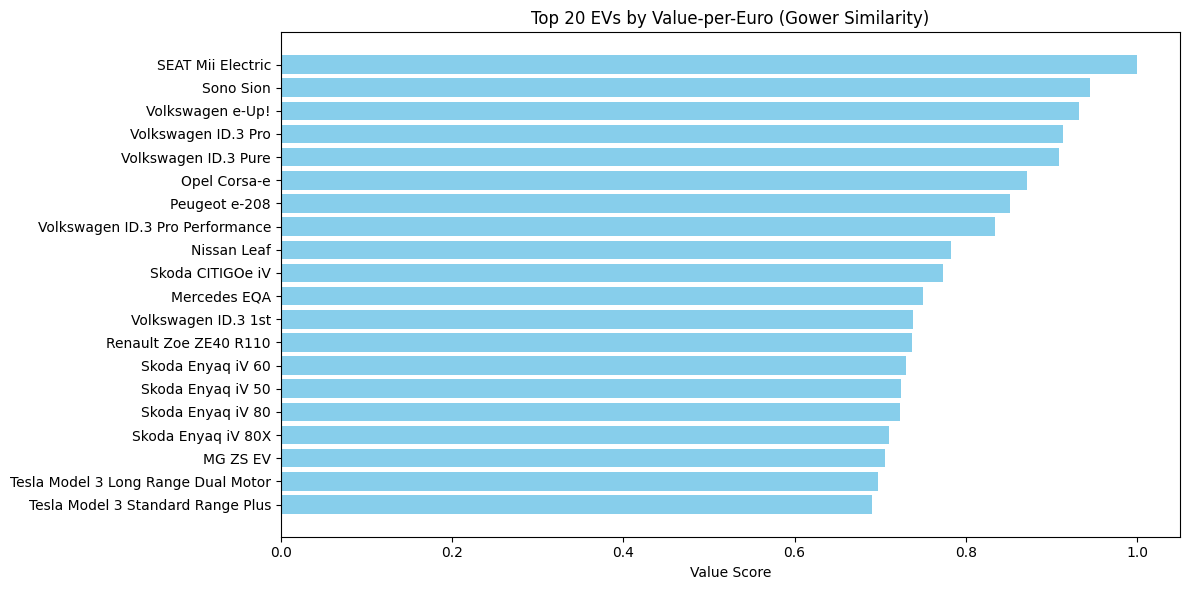

,Brand,Model,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,Charge_KmH,RapidCharge,PowerTrain,PlugType,BodyStyle,Seats,PriceEuro,PowerTrainScore,RapidChargeScore,GowerSimilarity,RawValueScore,ValueScore
44,SEAT,Mii Electric,12.3,130,195,166,170,Yes,FWD,Type 2 CCS,Hatchback,4,20129,0.50,1,0.353821,0.000018,1.000000
74,Sono,Sion,9.0,140,225,156,270,Yes,FWD,Type 2 CCS,Hatchback,5,25500,0.50,1,0.428795,0.000017,0.945261
17,Volkswagen,e-Up!,11.9,130,195,166,170,Yes,FWD,Type 2 CCS,Hatchback,4,21421,0.50,1,0.356284,0.000017,0.932116
26,Volkswagen,ID.3 Pro,9.0,160,350,166,490,Yes,RWD,Type 2 CCS,Hatchback,5,33000,0.75,1,0.540423,0.000016,0.913729
1,Volkswagen,ID.3 Pure,10.0,160,270,167,250,Yes,RWD,Type 2 CCS,Hatchback,5,30000,0.75,1,0.489418,0.000016,0.909238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,Porsche,Taycan Turbo,3.2,260,390,215,810,Yes,AWD,Type 2 CCS,Sedan,4,148301,1.00,1,0.670236,0.000005,0.062163
72,Porsche,Taycan Cross Turismo,3.5,250,385,217,770,Yes,AWD,Type 2 CCS,Station,4,150000,1.00,1,0.656393,0.000004,0.051858
51,Tesla,Roadster,2.1,410,970,206,920,Yes,AWD,Type 2 CCS,Cabrio,4,215000,1.00,1,0.846833,0.000004,0.020459
68,Renault,Kangoo Maxi ZE 33,22.4,130,160,194,22,No,FWD,Type 2,SPV,5,38000,0.50,0,0.145766,0.000004,0.013076


In [48]:

# Encode categorical values
powertrain_map = {"AWD": 1.0, "RWD": 0.75, "FWD": 0.5}
df["PowerTrainScore"] = df["PowerTrain"].map(powertrain_map).fillna(0.5)
df["RapidChargeScore"] = df["RapidCharge"].apply(lambda x: 1 if str(x).lower() == "yes" else 0)

# Select columns for scoring (excluding PriceEuro from score)
score_columns = [
     "AccelSec", "TopSpeed_KmH", "Range_Km", "Efficiency_WhKm",
     "Charge_KmH", "Seats", "RapidChargeScore", "PowerTrainScore"
]


# Define ideal vehicle as a DataFrame row with best values
ideal_vehicle = pd.DataFrame({
    "AccelSec": [df["AccelSec"].min()],
    "TopSpeed_KmH": [df["TopSpeed_KmH"].max()],
    "Range_Km": [df["Range_Km"].max()],
    "Efficiency_WhKm": [df["Efficiency_WhKm"].min()],
    "Charge_KmH": [df["Charge_KmH"].max()],
    "Seats": [df["Seats"].max()],
    "RapidChargeScore": [1],
    "PowerTrainScore": [1.0]
})

# Compute Gower similarity between each vehicle and the ideal vehicle
gower_similarities = 1 - gower.gower_matrix(pd.concat([ideal_vehicle, df[score_columns]], ignore_index=True))[0][1:]
df["GowerSimilarity"] = gower_similarities

# Compute value score: similarity per euro, then scale to [0, 1]
df["RawValueScore"] = df["GowerSimilarity"] / df["PriceEuro"]
df["ValueScore"] = (df["RawValueScore"] - df["RawValueScore"].min()) / (df["RawValueScore"].max() - df["RawValueScore"].min())

# Sort and show top result
top_vehicle = df.sort_values("ValueScore", ascending=False).iloc[0]

# Output top vehicle details
print("Best Value-per-Euro Vehicle (Gower similarity):")
print(top_vehicle[["Brand", "Model", "ValueScore"]])

# Visualization: top 20 vehicles by ValueScore
top_20 = df.sort_values("ValueScore", ascending=False).head(20)
plt.figure(figsize=(12, 6))
plt.barh(top_20["Brand"] + " " + top_20["Model"], top_20["ValueScore"], color='skyblue')
plt.xlabel("Value Score")
plt.title("Top 20 EVs by Value-per-Euro (Gower Similarity)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

df.dropna()

df.sort_values("ValueScore", ascending=False)
# df.sort_values("ValueScore", ascending=True)